# Processing the Data

It is assumed that within this directory, the raw OLID and HASOC datasets in VUA format are present, e.g.:
```
.
├── ...
└── data
    └── raw
        ├── hasoc-train.csv
        ├── olid-test.csv
        ├── olid-train-small.csv
        └── olid-train.csv
```

In [20]:
# !pip install emoji
# !pip install vaderSentiment
# !pip install advertools
# !pip install NRCLex
# !python -m textblob.download_corpora

In [21]:
import pandas as pd
import re
import emoji
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer

from collections import Counter
import re
import advertools as adv
from nrclex import NRCLex

In [22]:
df_train_olid_small = pd.read_csv('data/raw/olid-train-small.csv')
df_train_hasoc = pd.read_csv('data/raw/hasoc-train.csv')
df_test_olid = pd.read_csv('data/raw/olid-test.csv')

# Pipeline

In [23]:
NULL_STRING = ""

In [24]:
def showcase_transformation(f, text):
    before = text
    after = f(text)
    
    res = pd.DataFrame([
        {'': 'Before', 'text': before},
        {'': 'After', 'text': after}
    ])
    res = res.set_index('')
    return res

pd.options.display.max_colwidth = 100

## Processing mentions

First we remove all mentions of users.
Within both datasets, these are already processed to `@user` (hence, removing the specific Twitter profile mentioned).

In [25]:
REGEXP_USER_MENTION = "@[A-Za-z0-9_]+"

def process_mention(text):
    result = re.sub(REGEXP_USER_MENTION, NULL_STRING, text)
    return result

example_instance = 'Good morning @user @user @user @user @user @user' 

showcase_transformation(process_mention, example_instance)

,text
,
Before,Good morning @user @user @user @user @user @user
After,Good morning


## Removing hashtags

We also remove hashtags.

In [26]:
REGEXP_HASHTAG = "#[A-Za-z0-9_]+"

def process_hashtag(text):
    result = re.sub(REGEXP_HASHTAG, NULL_STRING, text)
    return result

example_instance = 'Just got a new computer #winning'

showcase_transformation(process_hashtag, example_instance)

,text
,
Before,Just got a new computer #winning
After,Just got a new computer


## Representing emojis with text

Emojis are changed to a text version.

In [27]:
def process_emoji(text):
    result = emoji.demojize(text, delimiters=(" ", " "))
    return result

example_instance = "how can mirrors be real if your eyes aren't real 🤔🤔"

showcase_transformation(process_emoji, example_instance)

,text
,
Before,how can mirrors be real if your eyes aren't real 🤔🤔
After,how can mirrors be real if your eyes aren't real thinking_face thinking_face


## Lowercasing text

As the BERT models we utilise assume uncased text, we lowercase the text 

In [28]:
def lowercase_text(text):
    result = str.lower(text)
    return result

example_instance = 'This should not have casing'

showcase_transformation(lowercase_text, example_instance)

,text
,
Before,This should not have casing
After,this should not have casing


## VADER Sentiment scores

[VADER](https://github.com/cjhutto/vaderSentiment) is a framework for computing sentiment scores specifically designed for social media.

In [29]:
analyser = SentimentIntensityAnalyzer()

def get_vader_polarity_scores(text):
    result = analyser.polarity_scores(text)
    return result

example_instance = 'the weather is :-/'
get_vader_polarity_scores(example_instance)

{'neg': 0.423, 'neu': 0.577, 'pos': 0.0, 'compound': -0.296}

## NRC Emotion Scores

In [30]:
def get_nrc_emotion_scores(text):
    result = NRCLex(text).affect_frequencies
    return result

example_instance = 'I enjoy apples'
get_nrc_emotion_scores(example_instance)

{'fear': 0.0,
 'anger': 0.0,
 'anticip': 0.0,
 'trust': 0.25,
 'surprise': 0.0,
 'positive': 0.25,
 'negative': 0.0,
 'sadness': 0.0,
 'disgust': 0.0,
 'joy': 0.25,
 'anticipation': 0.25}

## Counts

Here we extract numerous counts of textual features.

In [31]:
def get_counts(text):
    counts = {}
    counts['hashtag'] = text.count('#')
    counts['at'] = text.count('@')
    counts['exclamation'] = text.count('!')
    counts['character'] = len(text)
    counts['word'] = len(text.split())
    counts['capital_letter'] = len(re.findall(r'[A-Z]', text))
    counts['emoji'] = adv.extract_emoji(text)['overview']['num_emoji']
    return counts

get_counts('@user Nice job! 👍 #winning')

{'hashtag': 1,
 'at': 1,
 'exclamation': 1,
 'character': 26,
 'word': 5,
 'capital_letter': 1,
 'emoji': 1}

# Applying all functions

In [32]:
from sklearn.pipeline import Pipeline

In [33]:
pipeline = [
    process_mention,
    process_hashtag,
    process_emoji,
    lowercase_text
]

In [34]:
import mapply # pandas apply alternative that uses multiprocessing

In [35]:
COLUMN_ORDER = ['id', 'text', 'labels',
       'sentiment_score_neg', 'sentiment_score_neu', 'sentiment_score_pos',
       'sentiment_score_compound', 'hashtag_count', 'at_count',
       'exclamation_count', 'character_count', 'word_count', 'capital_letter_count',
       'emoji_count', 'fear', 'anger', 'anticip', 'trust', 'surprise',
       'positive', 'negative', 'sadness', 'disgust', 'joy', 'anticipation']

def process_row(row):
    # VADER Polarity scores
    vader_polarity = get_vader_polarity_scores(row['text'])
    for key, value in vader_polarity.items():
        row['sentiment_score_' + key] = value
    
    # NRC Emotion scores
    nrc_emotion_scores = get_nrc_emotion_scores(row['text'])
    for emotion, value in nrc_emotion_scores.items():
        row[emotion] = value
    
    # Count features
    count_features = get_counts(row['text'])
    for feature, value in count_features.items():
        row[feature + '_count'] = value
    
    # Clean text
    clean_text = row['text']
    for func in pipeline:
        clean_text = func(clean_text)
    row['text'] = clean_text
    
    return row

def process_df(df):
    mapply.init(n_workers=8)
    df = df.mapply(process_row, axis=1)
    df = df[COLUMN_ORDER]
    df['anticipation'] = df['anticipation'].fillna(0)
    return df

In [36]:
df_train_hasoc_featurized = process_df(df_train_hasoc)
df_train_hasoc_featurized.to_csv('data/processed/hasoc-train.csv', index=False)

  0%|                                                                                                         …

In [37]:
df_test_olid_featurized = process_df(df_test_olid)
df_test_olid_featurized.to_csv('data/processed/olid-test.csv', index=False)

  0%|                                                                                                         …

In [38]:
df_train_olid_small_featurized = process_df(df_train_olid_small)
df_train_olid_small_featurized.to_csv('data/processed/olid-train-small.csv', index=False)

  0%|                                                                                                         …

# Visual Inspection

In [39]:
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

In [40]:
dff = df_train_hasoc_featurized

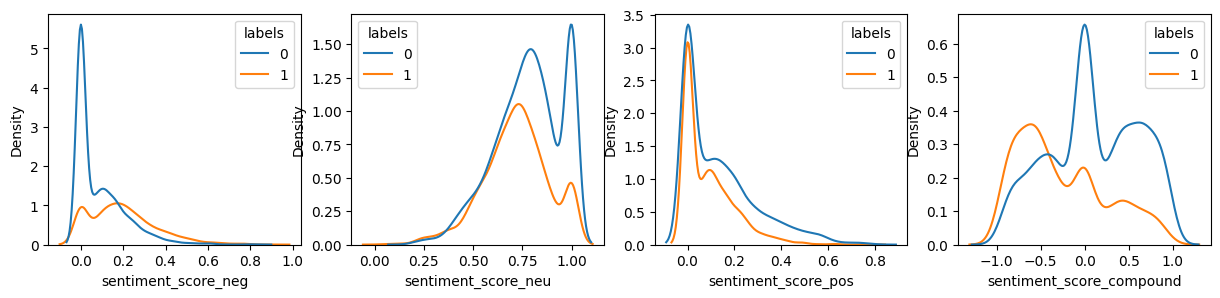

In [41]:
sentiment_scores = [col for col in dff.columns if 'sentiment' in col]

fig, axs = plt.subplots(nrows=1, ncols=4, figsize=(15, 3))
for i, item in enumerate(sentiment_scores):
    sns.kdeplot(data=df_train_olid_small_featurized, x=item, hue='labels', ax=axs[i])

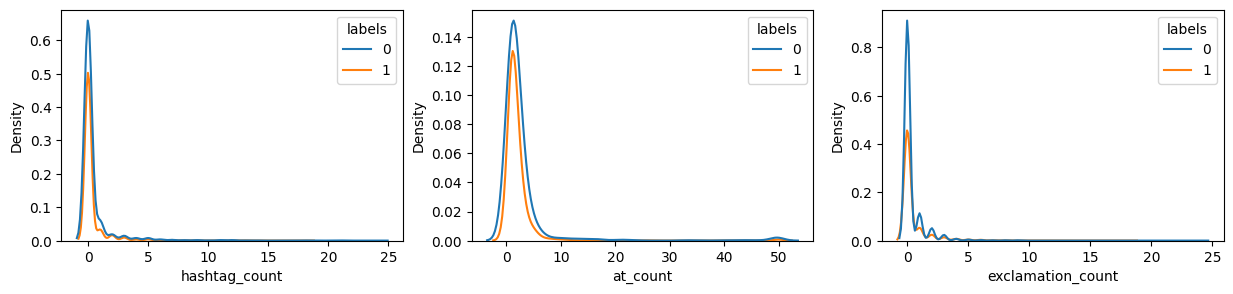

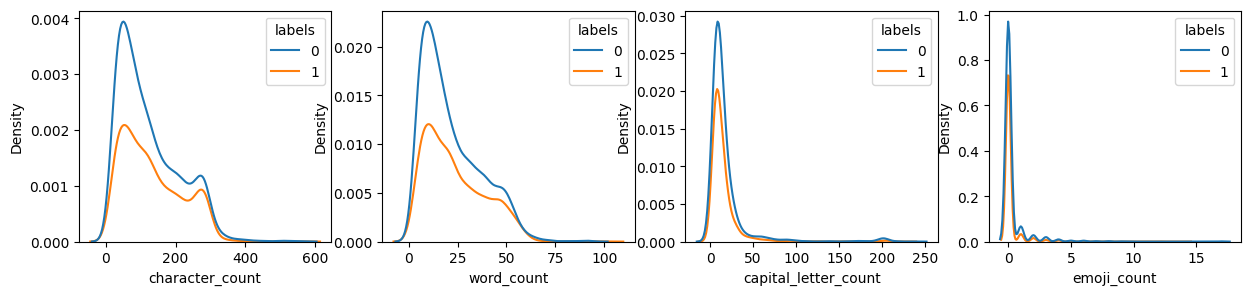

In [42]:
counts = [col for col in dff.columns if 'count' in col]

fig, axs = plt.subplots(nrows=1, ncols=3, figsize=(15, 3))
for i, item in enumerate(counts[:3]):
    sns.kdeplot(data=df_train_olid_small_featurized, x=item, hue='labels', ax=axs[i])
    
fig, axs = plt.subplots(nrows=1, ncols=4, figsize=(15, 3))
for i, item in enumerate(counts[3:]):
    sns.kdeplot(data=df_train_olid_small_featurized, x=item, hue='labels', ax=axs[i])

/tmp/ipykernel_5257/1897316891.py:7: UserWarning: Dataset has 0 variance; skipping density estimate. Pass `warn_singular=False` to disable this warning.
  sns.kdeplot(data=df_train_olid_small_featurized, x=item, hue='labels', ax=axs[i])


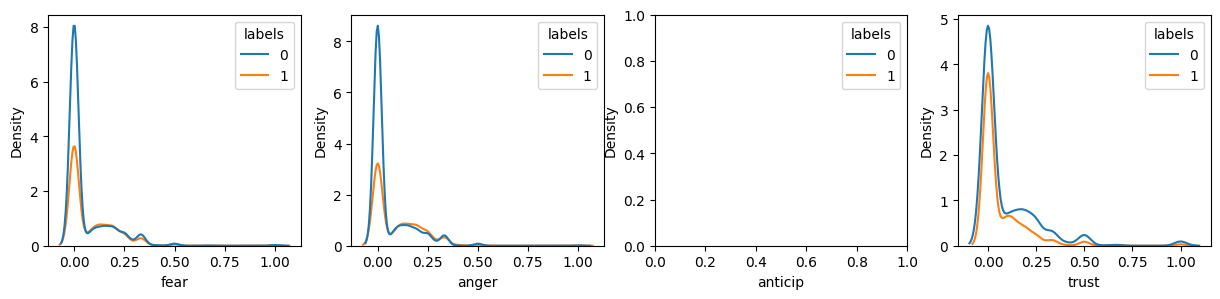

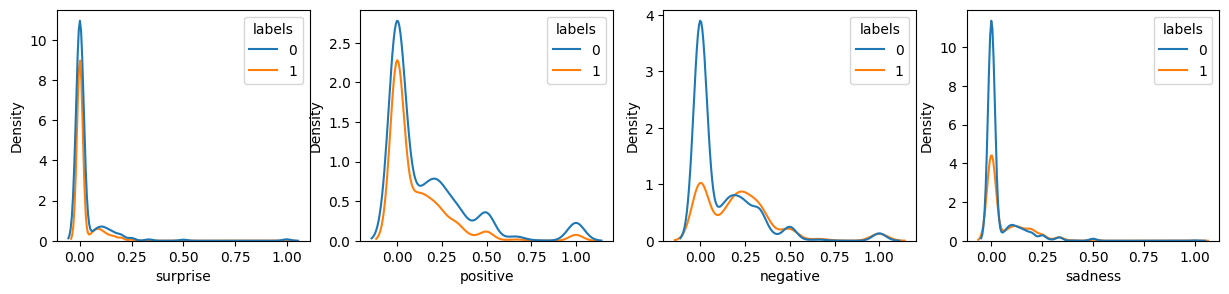

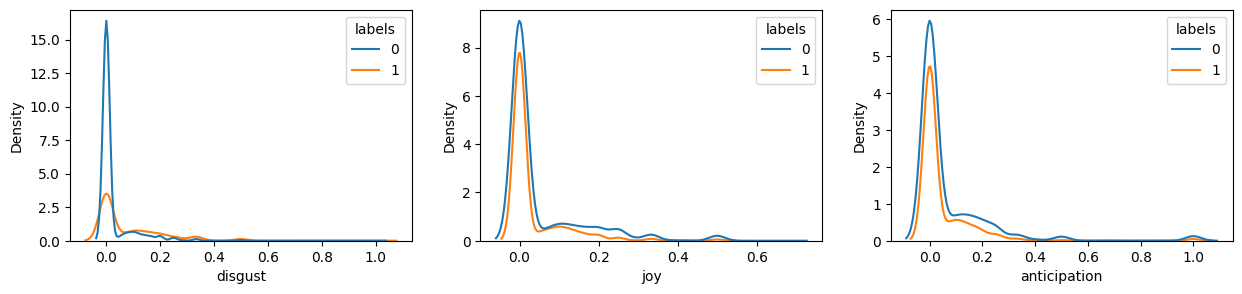

In [43]:
emotions = ['fear', 'anger', 'anticip',
       'trust', 'surprise', 'positive', 'negative', 'sadness', 'disgust',
       'joy', 'anticipation']

fig, axs = plt.subplots(nrows=1, ncols=4, figsize=(15, 3))
for i, item in enumerate(emotions[:4]):
    sns.kdeplot(data=df_train_olid_small_featurized, x=item, hue='labels', ax=axs[i])
    
fig, axs = plt.subplots(nrows=1, ncols=4, figsize=(15, 3))
for i, item in enumerate(emotions[4:8]):
    sns.kdeplot(data=df_train_olid_small_featurized, x=item, hue='labels', ax=axs[i])
    
fig, axs = plt.subplots(nrows=1, ncols=3, figsize=(15, 3))
for i, item in enumerate(emotions[8:]):
    sns.kdeplot(data=df_train_olid_small_featurized, x=item, hue='labels', ax=axs[i])